# Demo: RAIL Evaluation 

Author: Sam Schmidt, Alex Malz, Julia Gschwend, others...

last run successfully: March 16, 2022

The purpose of this notebook is to demonstrate the application of the metrics scripts to be used on the photo-z PDF catalogs produced by the PZ working group. The first implementation of the _evaluation_ module is based on the refactoring of the code used in [Schmidt et al. 2020](https://arxiv.org/pdf/2001.03621.pdf), available on Github repository [PZDC1paper](https://github.com/LSSTDESC/PZDC1paper). 

To run this notebook, you must install qp and have the notebook in the same directory as `utils.py` (available in RAIL's examples directrory). You must also have installed all RAIL dependencies, particularly for the estimation codes that you want to run, as well as ceci, qp, tables_io, etc...  See the RAIL installation instructions for more info.

### Contents

* [Data](#data)
 - [Photo-z Results](#fzboost)
* [CDF-based metrics](#metrics)
 - [PIT](#pit) 
 - [QQ plot](#qq) 
* [Summary statistics of CDF-based metrics](#summary_stats)
  - [KS](#ks) 
  - [CvM](#cvm) 
  - [AD](#ad) 
  - [KLD](#kld) 
* [CDE loss](#cde_loss)  

In [1]:
import rail
from rail.evaluation.metrics.pit import *
from rail.evaluation.metrics.cdeloss import *
from rail.evaluation.evaluator import Evaluator
from rail.core.data import QPHandle, TableHandle
from rail.core.stage import RailStage
from utils import plot_pit_qq, ks_plot
import qp 
import os
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Let's set up the data store, for more information on the data store, see the golden spike example notebook in RAIL/examples/goldenspike/goldenspike.ipynb

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

<a class="anchor" id="data"></a>
# Data  


To compute the photo-z metrics of a given test sample, it is necessary to read the output of a photo-z code containing galaxies' photo-z PDFs. Let's use the toy data available in `tests/data/` (**test_dc2_training_9816.hdf5** and **test_dc2_validation_9816.hdf5**) to generate a small sample of photo-z PDFs using the **FZBoost** algorithm available on RAIL's _estimation_ module.

<a class="anchor" id="fzboost"></a>
### Photo-z Results
#### Run FZBoost

Go to dir  `<your_path>/RAIL/examples/estimation/` and run the notebook `RAIL_estimation_demo.ipynb`, this will produce a file `output_fzboost.fits`

writen at the location:<br> 
`<your_path>/RAIL/examples/estimation/output_fzboost.fits`. 
This will read in the FZBoost PDF results as a qp Ensemble.


Next we need to set up some  paths for the Data Store:

In [3]:
from rail.core.utils import RAILDIR
pdfs_file =  os.path.join(RAILDIR, "examples/estimation/output_fzboost.hdf5")
ztrue_file =  os.path.join(RAILDIR, "tests/data/test_dc2_validation_9816.hdf5")

Read the data in, note that the fzdata is a `qp` Ensemble, and thus we should read it in as a `QPHandle` type file, while the ztrue_data is tabular data, and should be read in as a `Tablehandle` when adding to the data store

In [4]:
fzdata = DS.read_file('pdfs_data', QPHandle, pdfs_file)
ztrue_data = DS.read_file('ztrue_data', TableHandle, ztrue_file)

In [5]:
ztrue = ztrue_data()['photometry']['redshift']
zgrid = fzdata().metadata()['xvals'].ravel()
photoz_mode = fzdata().mode(grid=zgrid)

In [6]:
truth = DS.add_data('truth', ztrue_data()['photometry'], TableHandle)
ensemble = DS.add_data('ensemble', fzdata, QPHandle)

In [7]:
DS.keys()

dict_keys(['pdfs_data', 'ztrue_data', 'truth', 'ensemble'])

# Make an evaulator stage

Now let's set up the Evaluator stage to compute our metrics for the FZBoost data

In [8]:
FZB_eval = Evaluator.make_stage(name='FZB_eval', truth=truth)

In [9]:
FZB_results = FZB_eval.evaluate(ensemble(), truth)

/Users/echarles/software/DESC/RAIL/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_FZB_eval: inprogress_output_FZB_eval.hdf5, FZB_eval
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'


We can view the results as a pandas dataframe:

In [10]:
import tables_io
results_df= tables_io.convertObj(FZB_results(), tables_io.types.PD_DATAFRAME)
results_df

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.03393,6.879238e-21,8.312005,5.569367e-11,0.04307,0.020947,0.000157,0.106118,0.020922,-6.722552,NaN


So, there we have it, a way to generate all of our summary statistics for FZBoost. And note also that the results file has been written out to `output_FZB_eval.hdf5`, the name we specified when we ran `make_stage` (with output_ prepended).<br>

As an alternative, and to allow for a little more explanation for each individual metric, we can calculate the metrics using functions from the evaluation class separate from the stage infrastructure.  Here are some examples below.

*** 
<a class="anchor" id="metrics"></a>
# Metrics



<a class="anchor" id="pit"></a>
## PIT

The Probability Integral Transform (PIT), is the Cumulative Distribution Function (CDF) of the photo-z PDF 

$$ \mathrm{CDF}(f, q)\ =\ \int_{-\infty}^{q}\ f(z)\ dz $$

evaluated at the galaxy's true redshift for every galaxy $i$ in the catalog.

$$ \mathrm{PIT}(p_{i}(z);\ z_{i})\ =\ \int_{-\infty}^{z^{true}_{i}}\ p_{i}(z)\ dz $$ 


In [11]:
pitobj = PIT(fzdata(), ztrue)
quant_ens, metamets = pitobj.evaluate()

/Users/echarles/software/DESC/RAIL/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


The _evaluate_ method PIT class returns two objects, a quantile distribution based on the full set of PIT values (a frozen distribution object), and a dictionary of meta metrics associated to PIT (to be detailed below). 

In [12]:
quant_ens

In [13]:
metamets

{(rail.evaluation.metrics.pit.PITOutRate, 'default'): 0.04306984657462756,
 (rail.evaluation.metrics.pit.PITAD,
  'default'): stat_crit_sig(statistic=81.70963805764201, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}

PIT values

In [14]:
pit_vals = np.array(pitobj._pit_samps)
pit_vals

array([0.1991479 , 0.37565454, 0.51578139, ..., 1.        , 0.95779724,
       0.44688439])

### PIT outlier rate

The PIT outlier rate is a global metric defined as the fraction of galaxies in the sample with extreme PIT values. The lower and upper limits for considering a PIT as outlier are optional parameters set at the Metrics instantiation (default values are: PIT $<10^{-4}$ or PIT $>0.9999$). 

In [15]:
pit_out_rate = PITOutRate(pit_vals, quant_ens).evaluate()
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}") 

PIT outlier rate of this sample: 0.043070


<a class="anchor" id="qq"></a>
## PIT-QQ plot

The histogram of PIT values is a useful tool for a qualitative assessment of PDFs quality. It shows whether the PDFs are:
* biased (tilted PIT histogram)
* under-dispersed (excess counts close to the boudaries 0 and 1)
* over-dispersed (lack of counts close the boudaries 0 and 1)
* well-calibrated (flat histogram)

Following the standards in DC1 paper, the PIT histogram is accompanied by the quantile-quantile (QQ), which can be used to compare qualitatively the PIT distribution obtained with the PDFs agaist the ideal case (uniform distribution). The closer the QQ plot is to the diagonal, the better is the PDFs calibration. 

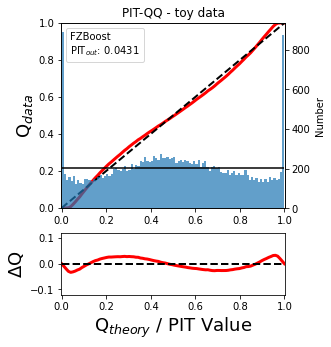

In [16]:
pdfs = fzdata.data.objdata()['yvals']
plot_pit_qq(pdfs, zgrid, ztrue, title="PIT-QQ - toy data", code="FZBoost",
                pit_out_rate=pit_out_rate, savefig=False)

The black horizontal line represents the ideal case where the PIT histogram would behave as a uniform distribution U(0,1). 
***

<a class="anchor" id="summary_stats"></a>
# Summary statistics of CDF-based metrics

To evaluate globally the quality of PDFs estimates, `rail.evaluation` provides a set of metrics to compare the empirical distributions of PIT values with the reference uniform distribution, U(0,1). 

<a class="anchor" id="ks"></a>
### Kolmogorov-Smirnov  

Let's start with the traditional Kolmogorov-Smirnov (KS) statistic test, which is the maximum difference between the empirical and the expected cumulative distributions of PIT values:

$$
\mathrm{KS} \equiv \max_{PIT} \Big( \left| \ \mathrm{CDF} \small[ \hat{f}, z \small] - \mathrm{CDF} \small[ \tilde{f}, z \small] \  \right| \Big)
$$

Where $\hat{f}$ is the PIT distribution and $\tilde{f}$ is U(0,1). Therefore, the smaller value of KS the closer the PIT distribution is to be uniform. The `evaluate` method of the PITKS class returns a named tuple with the statistic and p-value. 

In [17]:
ksobj = PITKS(pit_vals, quant_ens)
ks_stat_and_pval = ksobj.evaluate()

In [18]:
ks_stat_and_pval

stat_and_pval(statistic=0.03393041159163015, p_value=6.87923792324291e-21)

Visual interpretation of the KS statistic:

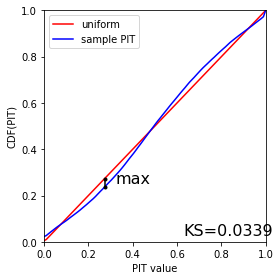

In [19]:
ks_plot(pitobj)

In [20]:
print(f"KS metric of this sample: {ks_stat_and_pval.statistic:.4f}") 

KS metric of this sample: 0.0339


<a class="anchor" id="cvm"></a>
### Cramer-von Mises

Similarly, let's calculate the Cramer-von Mises (CvM) test, a variant of the KS statistic defined as the mean-square difference between the CDFs of an empirical PDF and the true PDFs:

$$ \mathrm{CvM}^2 \equiv \int_{-\infty}^{\infty} \Big( \mathrm{CDF} \small[ \hat{f}, z \small] \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \Big)^{2} \mathrm{dCDF}(\tilde{f}, z) $$ 


on the distribution of PIT values, which should be uniform if the PDFs are perfect.

In [21]:
cvmobj = PITCvM(pit_vals, quant_ens)
cvm_stat_and_pval = cvmobj.evaluate()

In [22]:
print(f"CvM metric of this sample: {cvm_stat_and_pval.statistic:.4f}") 

CvM metric of this sample: 8.3120


<a class="anchor" id="ad"></a>
### Anderson-Darling 

Another variation of the KS statistic is the Anderson-Darling (AD) test, a weighted mean-squared difference featuring enhanced sensitivity to discrepancies in the tails of the distribution. 

$$ \mathrm{AD}^2 \equiv N_{tot} \int_{-\infty}^{\infty} \frac{\big( \mathrm{CDF} \small[ \hat{f}, z \small] \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \big)^{2}}{\mathrm{CDF} \small[ \tilde{f}, z \small] \big( 1 \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \big)}\mathrm{dCDF}(\tilde{f}, z) $$ 



In [23]:
adobj = PITAD(pit_vals, quant_ens)
ad_stat_crit_sig = adobj.evaluate()
ad_stat_crit_sig

stat_crit_sig(statistic=81.70963805764201, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [24]:
ad_stat_crit_sig

stat_crit_sig(statistic=81.70963805764201, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [25]:
print(f"AD metric of this sample: {ad_stat_crit_sig.statistic:.4f}") 

AD metric of this sample: 81.7096


It is possible to remove catastrophic outliers before calculating the integral for the sake of preserving numerical instability. For instance, Schmidt et al. computed the Anderson-Darling statistic within the interval (0.01, 0.99).

In [26]:
ad_stat_crit_sig_cut = adobj.evaluate(pit_min=0.01, pit_max=0.99)
print(f"AD metric of this sample: {ad_stat_crit_sig.statistic:.4f}") 
print(f"AD metric for 0.01 < PIT < 0.99: {ad_stat_crit_sig_cut.statistic:.4f}") 

1769 PITs removed from the sample.
AD metric of this sample: 81.7096
AD metric for 0.01 < PIT < 0.99: 76.9538


<a class="anchor" id="cde_loss"></a>
# CDE Loss



In the absence of true photo-z posteriors, the metric used to evaluate individual PDFs is the **Conditional Density Estimate (CDE) Loss**, a metric analogue to the root-mean-squared-error:

$$ L(f, \hat{f}) \equiv  \int \int {\big(f(z | x) - \hat{f}(z | x) \big)}^{2} dzdP(x), $$ 

where $f(z | x)$ is the true photo-z PDF and $\hat{f}(z | x)$ is the estimated PDF in terms of the photometry $x$. Since $f(z | x)$  is unknown, we estimate the **CDE Loss** as described in [Izbicki & Lee, 2017 (arXiv:1704.08095)](https://arxiv.org/abs/1704.08095). :

$$ \mathrm{CDE} = \mathbb{E}\big(  \int{{\hat{f}(z | X)}^2 dz} \big) - 2{\mathbb{E}}_{X, Z}\big(\hat{f}(Z, X) \big) + K_{f},  $$


where the first term is the expectation value of photo-z posterior with respect to the marginal distribution of the covariates X, and the second term is the expectation value  with respect to the joint distribution of observables X and the space Z of all possible redshifts (in practice, the centroids of the PDF bins), and the third term is a constant depending on the true conditional densities $f(z | x)$. 

In [27]:
cdelossobj = CDELoss(fzdata.data, zgrid, ztrue)

In [28]:
cde_stat_and_pval = cdelossobj.evaluate()
cde_stat_and_pval

stat_and_pval(statistic=-6.704263042608019, p_value=nan)

In [29]:
print(f"CDE loss of this sample: {cde_stat_and_pval.statistic:.2f}") 

CDE loss of this sample: -6.70


We note that all of the quantities as run individually are identical to the quantities in our summary table, a nice check that things have run properly